In [286]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [287]:
data = yf.download("ASIANPAINT.NS", start = "2013-07-08", end = "2023-07-08")

[*********************100%***********************]  1 of 1 completed


In [288]:
data.drop("Volume", inplace=True, axis = 1)

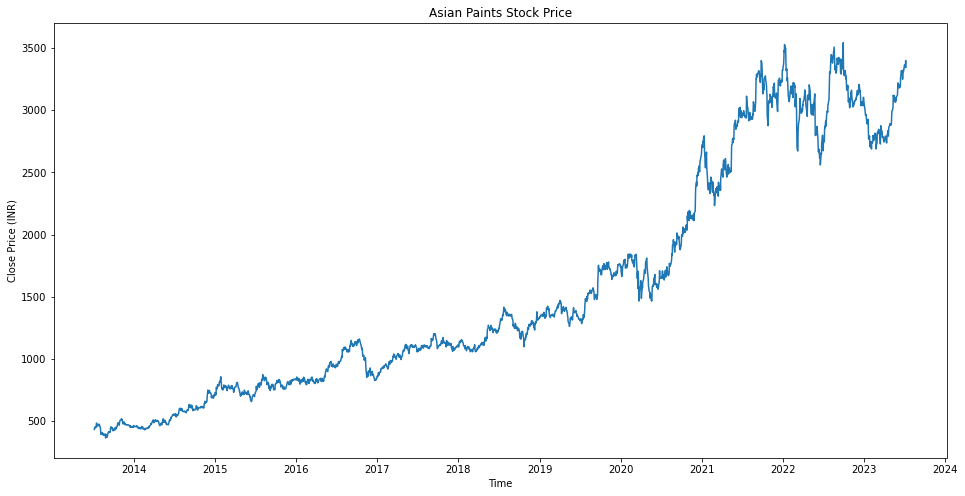

In [289]:
plt.figure(figsize= (16, 8))
plt.plot(data["Adj Close"])
plt.title("Asian Paints Stock Price")
plt.ylabel("Close Price (INR)")
plt.xlabel("Time")
plt.show()

In [290]:
def ATR(atr_lookback, High, Low, Close ):
    
    tr1 = pd.DataFrame(abs(High - Low))
    tr2 = pd.DataFrame(abs(High - Close.shift()))
    tr3 = pd.DataFrame(abs(Low - Close.shift()))
    true_range = pd.concat([tr1, tr2, tr3], axis = 1, join='inner').max(axis=1)
    # true_range_nifty = high_low_nifty.rolling(atr_period).mean()
    atr = true_range.ewm(span = atr_lookback, adjust = False).mean()
    return atr

def Keltner_Channel(high, low, close, kc_lookback=20, atr_period=10, multiplier=2):
    atr = ATR(atr_period, high, low, close)
    Ema = close.ewm(span = kc_lookback, adjust=False).mean()
    upper_band = Ema + (multiplier * atr)
    lower_band = Ema - (multiplier * atr)
    middle_band = Ema
    return upper_band, middle_band, lower_band

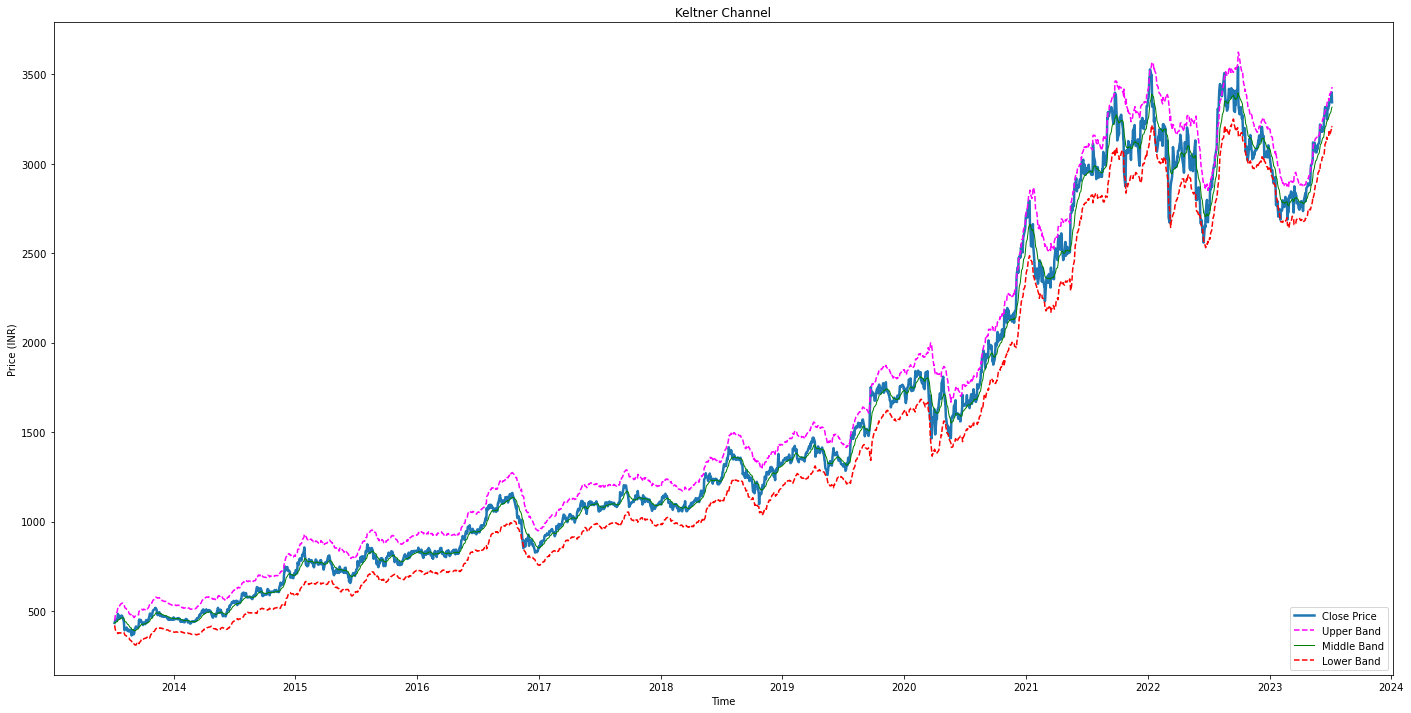

In [291]:
upper_kc, middle_kc, lower_kc = Keltner_Channel(data['High'], data['Low'], data['Adj Close'], 17, 10, 1.93) #using the results of the parameter optimization technique implemented in assignment 2
plt.figure(figsize=(24, 12))
plt.plot(data['Adj Close'], linewidth = 2.5, label ="Close Price")
plt.plot(upper_kc, linewidth = 1.5, linestyle = '--', label = "Upper Band", color = 'magenta')
plt.plot(middle_kc, linewidth = 1,  label = "Middle Band", color = 'green')
plt.plot(lower_kc, linewidth = 1.5, linestyle = '--', label = "Lower Band", color = 'red')
plt.title("Keltner Channel")
plt.ylabel("Price (INR)")
plt.xlabel("Time")
plt.legend(loc = 'lower right')
plt.show()


In [292]:
data['UpperBand'] = upper_kc 
data['LowerBand'] = lower_kc 

In [293]:
def is_hammer(candle):
    shadow_length = candle['High'] - max(candle['Close'], candle['Open'])
    body_length = abs(candle['Close'] - candle['Open'])
    return body_length <= 2 * shadow_length and shadow_length >= 2 * body_length

In [294]:
def Signal_Generation_Strategy(data):
    signal_df = pd.DataFrame(index=data.index)
    signal_df['Signal'] = 0
    signal_df.loc[data.index[0], 'Signal'] = 1
    curr =1
    
    for i in range(2, len(data)):
        current_candle = data.iloc[i]
        prev_candle = data.iloc[i - 1]
        threshold1 = 2.8*current_candle['UpperBand']/100.0
        threshold2 = 2.8*current_candle['LowerBand']/20.0
        
        if is_hammer(current_candle):
            difference = current_candle['Close'] - current_candle['UpperBand']
            if abs(difference) <= threshold1 and curr != -1:
                signal_df.loc[data.index[i], 'Signal'] = -1  # Sell signal
                curr = -1
            else:   
                difference = current_candle['Close'] - current_candle['LowerBand']
                if abs(difference) <= threshold2 and curr != 1:
                    signal_df.loc[data.index[i], 'Signal'] = 1  # Buy signal
                    curr = 1

    return signal_df

signal_df = Signal_Generation_Strategy(data)

In [295]:
def evaluate_strategy(data, signal_df):
    
    data['Return'] = data['Close'].pct_change()
    
    signal_df['Return'] = data['Return'] * signal_df['Signal'].shift()

    signal_df['CumulativeReturn'] = (1 + signal_df['Return']).cumprod()

    rolling_max = signal_df['CumulativeReturn'].cummax()
    signal_df['Drawdown'] = (signal_df['CumulativeReturn'] / rolling_max) - 1
    max_drawdown = signal_df['Drawdown'].min()

    sharpe_ratio = np.sqrt(252) * (signal_df['Return'].mean() / signal_df['Return'].std()) # risk free rate  = 0 

    return max_drawdown, sharpe_ratio, signal_df['CumulativeReturn'].iloc[-1]

In [296]:
max_drawdown, sharpe_ratio, cumulative_return = evaluate_strategy(data, signal_df)

print("Max Drawdown:", max_drawdown*100 , "%")
print("Sharpe Ratio:", sharpe_ratio)
print("Cumulative Return:", cumulative_return)

Max Drawdown: -5.478186412842345 %
Sharpe Ratio: 1.0437427253317282
Cumulative Return: 1.5857508631788104


In [297]:
signal_df['Adj Close'] = data['Adj Close']

Text(0.5, 1.0, 'Asian Pain Trading Strategy')

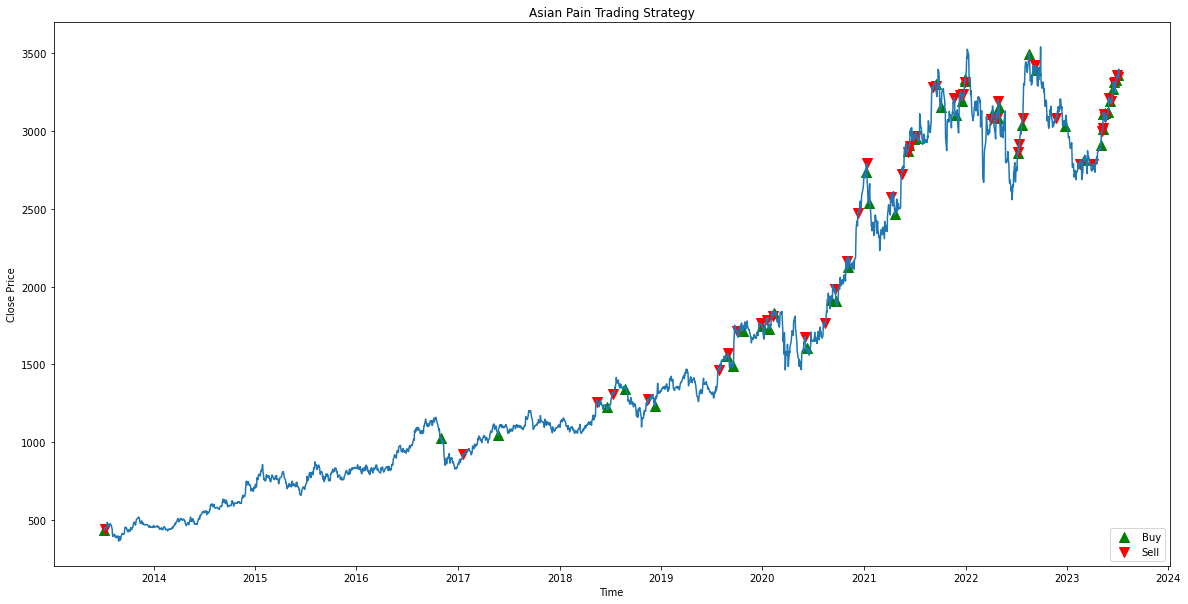

In [298]:
plt.figure(figsize=(20, 10))
plt.plot(data["Adj Close"], markersize = 2)

plt.scatter(signal_df[signal_df['Signal'] ==1].index, signal_df[signal_df['Signal'] ==1]['Adj Close'] , marker = '^', color = "green", label = "Buy", s= 100 )

plt.scatter(signal_df[signal_df['Signal'] ==-1].index, signal_df[signal_df['Signal'] ==-1]['Adj Close'] , marker = 'v', color = "red", label = "Sell" ,s = 100)

plt.legend(loc = "lower right" )

plt.xlabel("Time")
plt.ylabel('Close Price')
plt.title("Asian Pain Trading Strategy")